This is a test

3
3
3
5
3
6
5
7
4
8
5
7
6
4
14
6
4
10
4
[np.float64(943.6430948091195), np.float64(552.7944784895234), np.float64(339.3718537483549), np.float64(253.16763595442228), np.float64(252.88240921446456), np.float64(178.81758306794887), np.float64(162.29857979946118), np.float64(133.10116127348496), np.float64(113.08319278668044), np.float64(95.86963541707861), np.float64(80.42407635855605), np.float64(65.67491069702906), np.float64(59.81856054337185), np.float64(52.12432572872585), np.float64(51.21465213551432), np.float64(39.92943101836187), np.float64(40.45588551144958), np.float64(42.403036351671304), np.float64(34.9463555699142)]


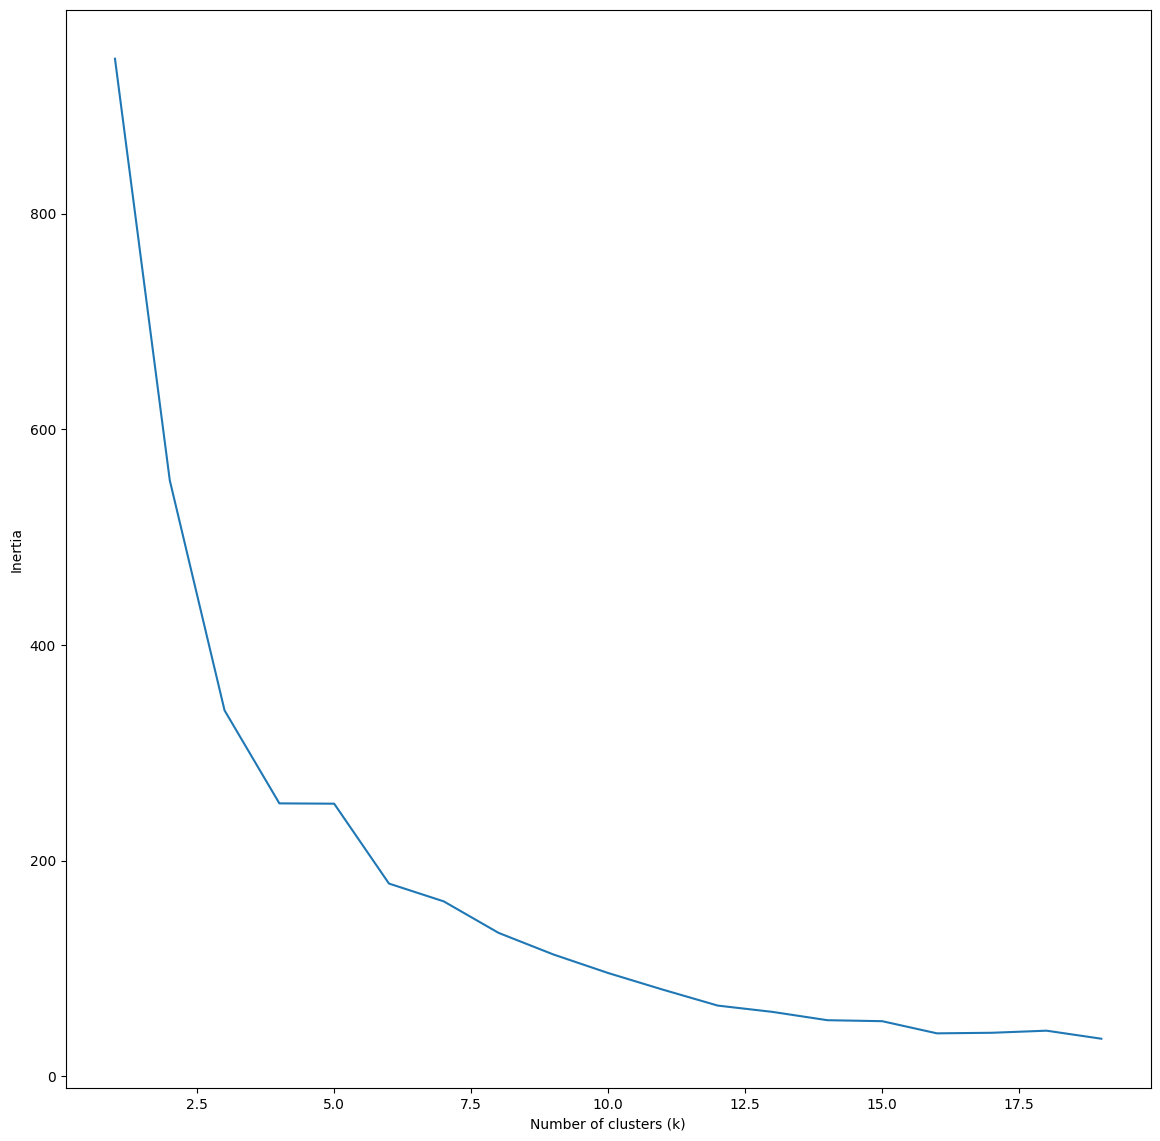

In [1]:
from main import main
main(number_of_clusters=12)

# ls -l